# Лабораторная 2

In [1]:
from abc import ABCMeta, abstractmethod
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [29]:
df = pd.read_csv("data\creditcard.csv")

In [30]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [31]:
class Classificator():
    __metaclass__ = ABCMeta
    
    @abstractmethod
    def train(X, Y):
        '''Обучить модель'''
    
    @abstractmethod
    def predict(self, X, tree):
        '''Предсказать данные'''

In [32]:
class DecisionTree(Classificator):
    
    def train(self, X, Y, tabs="", depth = 0, max_depth=None, leafValue=None):
        entropy = self.calculate_entropy(Y)
        node = {}
        if entropy == 0 or depth == max_depth or len(X) == leafValue or len(X.columns) == 0:
            p = 0
            if len(Y.loc[Y != 1]) == 0:
                p = 1
            elif len(Y.loc[Y == 1]) == 0:
                p = 0
            else:
                p = len(Y.loc[Y == 1]) / len(Y)
            node['label'] = p
            return node
        igs = []
        for index, row in X.iterrows():
            inner_igs = []
            for column in X:
                predicate = row[column]
                left = X[column].loc[X[column] <= predicate]
                right = X[column].loc[X[column] > predicate]
                Y_left = Y.loc[left.index]
                Y_right = Y.loc[right.index]
                groups = [[len(left), self.calculate_entropy(Y_left)], [len(right), self.calculate_entropy(Y_right)]]
                ig = self.information_gain(Y, entropy, groups)
                inner_igs.append(Predicate(column, ig, predicate))
            igs.append(self.get_max_ig(inner_igs))

        predicate = self.get_max_ig(igs)
        
        
        X_left = X.loc[X[predicate.attribute] <= predicate.predicate].drop(predicate.attribute, axis=1)
        X_right = X.loc[X[predicate.attribute] > predicate.predicate].drop(predicate.attribute, axis=1)
        Y_left = Y.loc[X_left.index]
        Y_right = Y.loc[X_right.index]
        depth += 1
        node['attribute'] = predicate.attribute
        node['value'] = predicate.predicate
        node['nodes'] = {}
        node['nodes']['<='] = DecisionTree().train(X_left, Y_left, depth=depth, max_depth=max_depth)
        node['nodes']['>'] = DecisionTree().train(X_right, Y_right, depth=depth, max_depth=max_depth)
        return node
    
    def predict(self, X, tree):
        X['target'] = [0 for i in range(len(X))]
        return self.set_label(X, tree)
    
    def set_label(self, X, tree):
        if 'label' in tree:
            X.target = tree['label']
            return X
        left = X.loc[X[tree['attribute']] <= tree['value']]
        X.loc[X[tree['attribute']] <= tree['value']] = self.set_label(left, tree['nodes']['<='])
        right = X.loc[X[tree['attribute']] > tree['value']]
        X.loc[X[tree['attribute']] > tree['value']] = self.set_label(right, tree['nodes']['>'])
        return X
    
    def calculate_entropy(self, Y):
        count = len(Y)
        entropy = 0
        for count_class in Y.value_counts():
            p = count_class / count
            entropy -= p * np.log2(p)
        return entropy
    
    
    def information_gain(self, Y, entropy0, groups):
        N = len(Y)
        sum_entropies = 0
        for group in groups:
            group
            Ni = group[0]
            Si = group[1]
            sum_entropies += Ni / N * Si
        return entropy0 - sum_entropies
    
    def get_max_ig(self, igs):
        information_gain = igs[0]
        for ig in igs:
            if ig.ig > information_gain.ig:
                information_gain = ig
        return information_gain

In [33]:
class RandomForest(Classificator):
    tree = DecisionTree()
    model = []
    
    def train(self, X, Y, N=10, max_depth=None):
        for i in range(N):
            Xn = X.sample(int(len(X) * 2 / 3), replace=True)
            Yn = Y.loc[Xn.index]
            self.model.append(self.create_tree(Xn, Yn, max_depth=max_depth))
        return self.model
    
    def create_tree(self, X, Y, depth=0, max_depth=None, min_leaf=None):
        entropy = self.tree.calculate_entropy(Y)
        node = {}
        if entropy == 0 or len(X.columns) == 0:
            p = 0
            if len(Y.loc[Y != 1]) == 0:
                p = 1
            elif len(Y.loc[Y == 1]) == 0:
                p = 0
            else:
                p = len(Y.loc[Y == 1]) / len(Y)
            node['label'] = p
            return node
        
        X = X.sample(int(np.sqrt(len(X.columns))), axis=1)
        igs = []
        for index, row in X.iterrows():
            inner_igs = []
            for column in X:
                predicate = row[column]
                left = X[column].loc[X[column] <= predicate]
                right = X[column].loc[X[column] > predicate]
                Y_left = Y.loc[left.index]
                Y_right = Y.loc[right.index]
                groups = [[len(left), self.tree.calculate_entropy(Y_left)], [len(right), self.tree.calculate_entropy(Y_right)]]
                ig = self.tree.information_gain(Y, entropy, groups)
                inner_igs.append(Predicate(column, ig, predicate))
            igs.append(self.tree.get_max_ig(inner_igs))

        predicate = self.tree.get_max_ig(igs)
        
        
        X_left = X.loc[X[predicate.attribute] <= predicate.predicate].drop(predicate.attribute, axis=1)
        X_right = X.loc[X[predicate.attribute] > predicate.predicate].drop(predicate.attribute, axis=1)
        Y_left = Y.loc[X_left.index]
        Y_right = Y.loc[X_right.index]
        depth += 1
        node['attribute'] = predicate.attribute
        node['value'] = predicate.predicate
        node['nodes'] = {}
        node['nodes']['<='] = self.create_tree(X_left, Y_left, depth=depth, max_depth=max_depth)
        node['nodes']['>'] = self.create_tree(X_right, Y_right, depth=depth, max_depth=max_depth)
        return node
    
    def predict(self, X):
        prediction_list = []
        res = []
        for m in self.model:
            prediction_list.append(self.tree.predict(X, tree=m))
        for i in prediction_list[0].target.index:
            label = 0
            for t in prediction_list:
                label += t.target[i]
            label /= len(prediction_list)
            res.append(label)
        return res

In [34]:
class GradientBoosting(Classificator):
    model = None
    
    def train(X, Y, M, h=None):
        gamma = Y.mode()
        losses = logistic_loss(Y, gamma)
        f0 = np.argmin(np.sum(losses))
        for t in range(M):
            r = logistic_loss_der(X, Y)
            h = DecisionTree().train(X, r)
            ro = min(sum(L(y), f(x) + ro * h(x)))
        return
    
    def logistic_loss(self, Y, gamma):
        L = []
        for y in Y[1:]:
            L.append(np.log(1 + np.exp(-2 * y * gamma)))
        return L
    
    def logistic_loss_der(self, X, Y):
        r = []
        for y in Y[1:]:
            r = 2 * y / (1 + np.exp(2 * y * f(x)))
        return -r
    
    def predict(self, X):
        pass

In [35]:
import matplotlib.pyplot as plt

class ROC_AUC():
    models = []
    labels = []
    
    def __init__(self, models, labels):
        self.models = models
        self.labels = labels
        
    def show(self):
        curves = []
        for m in self.models:
            FPR, TPR, AUC = self.roc_curve(m[0], m[1])
            plt.plot(FPR, TPR)
            print(AUC)
        plt.legend(self.labels)
        plt.show()
    
    def roc_curve(self, y_true, y_score):
        y = pd.DataFrame({'true' : y_true, 'score' : y_score}).reset_index()
        y_sorted = y.sort_values('score')
        m = len(y_true)
        m0 = (y_true == 0).sum()
        m1 = (y_true == 1).sum()
        FPR, TPR = ([0], [0])
        AUC = 0
        for i in range(1, m):
            if y.true[i] == 0:
                FPR.append(FPR[i - 1] + 1 / m0)
                TPR.append(TPR[i - 1])
                AUC += TPR[i] / m0
            else:
                FPR.append(FPR[i - 1])
                TPR.append(TPR[i - 1] + 1 / m1)
        return (FPR, TPR, AUC)
                

In [36]:
def read_tree(t, tabs='', d=''):
    print(tabs+'predicate: ' + d)
    if 'label' in t:
        print(tabs+'label: ' + str(t['label']))
    else:
        print(tabs+'attr: ' + t['attribute'])
        print(tabs+'val: ' + str(t['value']))
        read_tree(t['nodes']['<='], tabs+'\t', d='<=')
        read_tree(t['nodes']['>'], tabs+'\t', d='>')
    return

In [37]:
class Predicate:
    attribute = ""
    ig = 0
    predicate = 0
    
    def __init__(self, attribute, ig, predicate):
        self.attribute = attribute
        self.ig = ig
        self.predicate = predicate

In [51]:
models = []

In [52]:
len(df.loc[df.Class == 1])

492

In [55]:
temp0 = df.loc[df.Class == 1]
temp1 = df.loc[df.Class == 0].sample(n = 500)
temp = pd.concat([temp0, temp1]).reset_index(drop=True)

In [56]:
X = temp[temp.columns[:-1]]
y = temp.Class

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
tree = DecisionTree()
t = tree.train(X_train, Y_train, max_depth=3)
predicted = tree.predict(X_test, t)
models.append([Y_test, predicted.target])

C:\Users\adugeen\anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\adugeen\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\adugeen\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [58]:
forest = RandomForest()
f = forest.train(X_train, Y_train, max_depth=3)
predicted = forest.predict(X_test)
models.append([Y_test, predicted])

C:\Users\adugeen\anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\adugeen\anaconda3\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\adugeen\anaconda3\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.4858997768309999
0.4858997768309999
0.4858997768309999


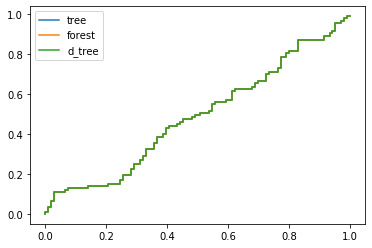

In [72]:
roc_auc = ROC_AUC(models, ['tree', 'forest', 'd_tree'])
roc_auc.show()

In [63]:
from sklearn.tree import DecisionTreeClassifier

d_tree = DecisionTreeClassifier(max_depth=3)
d_tree.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

array([1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0], dtype=int64)

In [71]:
models.append([Y_test, d_tree.predict(X_test[X_test.columns[:-1]])])